In [50]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import math
from scipy import stats

In [38]:
url = "https://drive.google.com/drive/folders/1RZJdNpCfbMt2SB_kfWsxQgOk5LeuV7lw"
gdown.download_folder(url)

Retrieving folder contents


Processing file 1fYGb-n114IGWZDcBKE0jzc3BWSLCcsVQ Divar.csv
Processing file 1eX9an3tSypvrFn_fiPReYHTca5GpJaJG iran_city_classification.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1fYGb-n114IGWZDcBKE0jzc3BWSLCcsVQ
From (redirected): https://drive.google.com/uc?id=1fYGb-n114IGWZDcBKE0jzc3BWSLCcsVQ&confirm=t&uuid=6b24b8d8-e4db-4da0-9e4e-006f9062497a
To: /content/Divar Dataset/Divar.csv
100%|██████████| 794M/794M [00:10<00:00, 76.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eX9an3tSypvrFn_fiPReYHTca5GpJaJG
To: /content/Divar Dataset/iran_city_classification.csv
100%|██████████| 6.16k/6.16k [00:00<00:00, 11.8MB/s]
Download completed


['/content/Divar Dataset/Divar.csv',
 '/content/Divar Dataset/iran_city_classification.csv']

In [39]:
df = pd.read_csv(
    "Divar Dataset/Divar.csv",
    low_memory=False
)

In [57]:
# =========================
# PREPARING DATA
# =========================

# 1) Helpers
def find_col(cands):
    """Return the first column name from cands that exists in df, else None."""
    for c in cands:
        if c in df.columns:
            return c
    return None

def normalize_digits(x):
    """Convert Persian/Arabic numerals to ASCII digits; keep other chars as-is."""
    if pd.isna(x):
        return x
    s = str(x)
    trans = str.maketrans("۰۱۲۳۴۵۶۷۸۹٠١٢٣٤٥٦٧٨٩", "01234567890123456789")
    return s.translate(trans)

def normalize_text(s):
    """Lowercase + normalize Arabic/Persian variants to improve matching."""
    if pd.isna(s):
        return ""
    s = str(s).lower()
    # unify Arabic vs Persian characters
    s = s.replace("ي", "ی").replace("ك", "ک")
    # remove extra spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

def to_bool_robust(x):
    """
    Robust yes/no parser:
    - True tokens: 1, true, yes, y, بله, بلی, دارد, هست
    - False tokens: 0, false, no, n, خیر, ندارد, نیست, بدون
    - Otherwise: try int cast, else NaN -> will be filled later
    """
    if pd.isna(x):
        return np.nan
    s = normalize_text(x)
    if s in {"1","true","yes","y","بله","بلی","دارد","هست"}:
        return True
    if s in {"0","false","no","n","خیر","ندارد","نیست","بدون"}:
        return False
    try:
        return bool(int(normalize_digits(x)))
    except:
        return np.nan

# 2) Detect columns (robust to common alternative names)
price_col = find_col(["value_price", "price_value"])
assert price_col, "Missing price column (value_price or price_value)."

year_col_raw = find_col(["construction_year", "year_construction"])
assert year_col_raw, "Missing construction year column (construction_year or year_construction)."

city_col = find_col(["slug_city", "city"])
lat_col  = find_col(["latitude_location", "latitude"])
lon_col  = find_col(["longitude_location", "longitude"])

size_build_col = find_col([
    "size_building","building_size","built_area","building_area","floor_area","area_building",
    "meterage_building","metrage_building","apartment_area","apartment_size",
    "size","area","meterage","metraj","metrage"
])
size_land_col  = find_col(["size_land","land_size","land_area","area_land","metrage_land"])

rooms_col    = find_col(["count_rooms","rooms"])
capacity_col = find_col(["regular_person_capacity","capacity_person","person_capacity"])
type_col     = find_col(["type_property","property_type","type","ad_type"])

# Known boolean amenity columns (if they exist)
luxury_cols = [c for c in ["pool_has","barbecue_has","sauna_has","jacuzzi_has"] if c in df.columns]
nonlux_cols = [c for c in [
    "balcony_has","elevator_has","warehouse_has","parking_has","guard_security_has",
    "system_heating_has","system_cooling_has","restroom_has","water_has","electricity_has","gas_has"
] if c in df.columns]

print("[Detected columns]")
print(" price_col         :", price_col)
print(" year_col_raw      :", year_col_raw)
print(" size_build_col    :", size_build_col)
print(" size_land_col     :", size_land_col)
print(" rooms_col         :", rooms_col)
print(" capacity_col      :", capacity_col)
print(" lat_col, lon_col  :", lat_col, lon_col)
print(" type_col          :", type_col)
print(" luxury_cols       :", luxury_cols)
print(" nonlux_cols       :", nonlux_cols)

# 3) Normalize digits on numeric-like columns BEFORE numeric casting
numeric_like_cols = [c for c in [
    price_col, year_col_raw, size_build_col, size_land_col,
    rooms_col, capacity_col, lat_col, lon_col
] if c]
for c in numeric_like_cols:
    df[c] = df[c].apply(normalize_digits)

# 4) Cast to numeric
for c in numeric_like_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 5) Clean & impute construction year (Shamsi)
df.loc[~df[year_col_raw].between(1300, 1500, inclusive="both"), year_col_raw] = np.nan
na_before_year = df[year_col_raw].isna()

group_orders = []
if city_col and type_col: group_orders.append([city_col, type_col])
if city_col:              group_orders.append([city_col])
if type_col:              group_orders.append([type_col])

for grp in group_orders:
    med = df.groupby(grp)[year_col_raw].transform("median")
    mask = df[year_col_raw].isna() & med.notna()
    df.loc[mask, year_col_raw] = med[mask]

global_median_year = df[year_col_raw].median(skipna=True)
df[year_col_raw] = df[year_col_raw].fillna(global_median_year)
df[year_col_raw] = df[year_col_raw].round().astype("Int64")
df["construction_year_imputed"] = na_before_year & df[year_col_raw].notna()

# Use construction year as analysis year
df["year_shamsi"] = df[year_col_raw]

# 6) Price cleaning & outlier control
df.loc[df[price_col] <= 0, price_col] = np.nan
q = df[price_col].quantile([0.01, 0.99])
if q.notna().all() and (q.iloc[0] < q.iloc[1]):
    df[price_col] = df[price_col].clip(lower=q.iloc[0], upper=q.iloc[1])
df["_log_price"] = np.log1p(df[price_col])

# 7) Size columns: clean invalid, impute hierarchically, winsorize
def impute_numeric(col, by_groups, min_positive=True, clip_quantiles=(0.01, 0.99)):
    if not col or col not in df.columns:
        return
    if min_positive:
        df.loc[df[col] <= 0, col] = np.nan
    na_before = df[col].isna()
    for grp in by_groups:
        med = df.groupby(grp)[col].transform("median")
        mask = df[col].isna() & med.notna()
        df.loc[mask, col] = med[mask]
    gmed = df[col].median(skipna=True)
    df[col] = df[col].fillna(gmed)
    lo, hi = df[col].quantile([0.01, 0.99])
    if pd.notna(lo) and pd.notna(hi) and lo < hi:
        df[col] = df[col].clip(lo, hi)
    df[f"{col}_imputed"] = na_before & df[col].notna()

by_groups = []
if city_col and type_col: by_groups.append([city_col, type_col])
if city_col:              by_groups.append([city_col])
if type_col:              by_groups.append([type_col])

impute_numeric(size_build_col, by_groups, min_positive=True)
impute_numeric(size_land_col,  by_groups, min_positive=True)

# 8) Rooms / capacity: clip to reasonable range, impute
def clip_impute_smallint(col, max_reasonable, default=0):
    if not col or col not in df.columns:
        return
    df.loc[(df[col] < 0) | (df[col] > max_reasonable), col] = np.nan
    na_before = df[col].isna()
    for grp in by_groups:
        med = df.groupby(grp)[col].transform("median")
        mask = df[col].isna() & med.notna()
        df.loc[mask, col] = med[mask]
    gmed = df[col].median(skipna=True)
    if pd.isna(gmed):
        gmed = default
    df[col] = df[col].fillna(gmed).round().astype(int)
    df[f"{col}_imputed"] = na_before & df[col].notna()

clip_impute_smallint(rooms_col,    max_reasonable=20, default=2)
clip_impute_smallint(capacity_col, max_reasonable=30, default=4)

# 9) Coordinates: clean invalid, impute by city if possible
if lat_col and lon_col:
    df.loc[~df[lat_col].between(-90, 90, inclusive="both"), lat_col] = np.nan
    df.loc[~df[lon_col].between(-180,180, inclusive="both"), lon_col] = np.nan
    na_lat = df[lat_col].isna(); na_lon = df[lon_col].isna()
    if city_col:
        for ccc in [lat_col, lon_col]:
            med = df.groupby(city_col)[ccc].transform("median")
            mask = df[ccc].isna() & med.notna()
            df.loc[mask, ccc] = med[mask]
    df[lat_col] = df[lat_col].fillna(df[lat_col].median(skipna=True)) if lat_col else None
    df[lon_col] = df[lon_col].fillna(df[lon_col].median(skipna=True)) if lon_col else None
    df[f"{lat_col}_imputed"] = na_lat & df[lat_col].notna() if lat_col else False
    df[f"{lon_col}_imputed"] = na_lon & df[lon_col].notna() if lon_col else False

# 10) Amenities / feature flags
# 10a) If explicit boolean columns exist, convert robustly
for c in (luxury_cols + nonlux_cols):
    df[c] = df[c].apply(to_bool_robust)

# After parsing, fill NAs to False and track imputation
for c in (luxury_cols + nonlux_cols):
    if c not in df.columns:
        continue
    na_b = df[c].isna()
    df[c] = df[c].fillna(False)
    df[f"{c}_imputed"] = na_b & df[c].notna()

# Roll-ups from explicit columns (if any)
has_lux_from_bool   = df[luxury_cols].any(axis=1) if luxury_cols else pd.Series(False, index=df.index)
has_nonlux_from_bool= df[nonlux_cols].any(axis=1) if nonlux_cols else pd.Series(False, index=df.index)

# 10b) Fallback: extract amenities from text columns if explicit booleans are missing OR all-False
# Candidate text columns where amenities often appear
text_candidates = [c for c in df.columns if any(k in c.lower() for k in
                    ["amenit","feature","facilit","option","equipment","spec","امکانات","ویژگی","مشخصات","description","desc","توضیحات"])]

has_text_candidates = len(text_candidates) > 0
need_text_extraction = has_text_candidates and ((luxury_cols == []) or (has_lux_from_bool.sum() == 0) or (has_nonlux_from_bool.sum() == 0))

if need_text_extraction:
    # Build a single lowercase normalized text field (vectorized join)
    text_series = df[text_candidates].astype(str).applymap(normalize_text).agg(" ".join, axis=1)

    # Define keyword patterns (English + Persian)
    # Luxury
    pat_pool     = r"(pool|swimming|استخر)"
    pat_bbq      = r"(barbecue|bbq|باربیکیو)"
    pat_sauna    = r"(sauna|سونا)"
    pat_jacuzzi  = r"(jacuzzi|hot\s*tub|جکوزی)"
    # Non-luxury
    pat_balcony  = r"(balcony|بالکن|تراس)"
    pat_elev     = r"(elevator|ascenseur|آسانسور)"
    pat_storage  = r"(warehouse|storage|انباری)"
    pat_parking  = r"(parking|پارکینگ)"
    pat_guard    = r"(guard|security|نگهبان|حراست|سرایداری)"
    pat_heat     = r"(heating|گرمایش|پکیج|شوفاژ|radiator)"
    pat_cool     = r"(cooling|سرمایش|کولر|چیلر|داکت\s*اسپلیت)"
    pat_rest     = r"(restroom|toilet|bathroom|سرویس|حمام|دستشویی)"
    pat_water    = r"(water|آب)"
    pat_elec     = r"(electricity|electric|برق)"
    pat_gas      = r"(gas|گاز)"

    # Vectorized contains
    has_pool    = text_series.str.contains(pat_pool,    regex=True, na=False)
    has_bbq     = text_series.str.contains(pat_bbq,     regex=True, na=False)
    has_sauna   = text_series.str.contains(pat_sauna,   regex=True, na=False)
    has_jacuzzi = text_series.str.contains(pat_jacuzzi, regex=True, na=False)

    has_balcony = text_series.str.contains(pat_balcony, regex=True, na=False)
    has_elev    = text_series.str.contains(pat_elev,    regex=True, na=False)
    has_store   = text_series.str.contains(pat_storage, regex=True, na=False)
    has_park    = text_series.str.contains(pat_parking, regex=True, na=False)
    has_guard   = text_series.str.contains(pat_guard,   regex=True, na=False)
    has_heat    = text_series.str.contains(pat_heat,    regex=True, na=False)
    has_cool    = text_series.str.contains(pat_cool,    regex=True, na=False)
    has_rest    = text_series.str.contains(pat_rest,    regex=True, na=False)
    has_water   = text_series.str.contains(pat_water,   regex=True, na=False)
    has_elec    = text_series.str.contains(pat_elec,    regex=True, na=False)
    has_gas     = text_series.str.contains(pat_gas,     regex=True, na=False)

    # Merge text-derived flags into roll-ups
    has_lux_from_text = has_pool | has_bbq | has_sauna | has_jacuzzi
    has_nonlux_from_text = (has_balcony | has_elev | has_store | has_park |
                            has_guard | has_heat | has_cool | has_rest | has_water | has_elec | has_gas)

    # Final roll-ups: boolean-cols OR text-cols
    has_lux_final    = has_lux_from_bool | has_lux_from_text
    has_nonlux_final = has_nonlux_from_bool | has_nonlux_from_text
else:
    has_lux_final    = has_lux_from_bool
    has_nonlux_final = has_nonlux_from_bool

df["has_luxury"]  = has_lux_final.fillna(False)
df["has_nonlux"]  = has_nonlux_final.fillna(False)

print("\n[Amenities detection]")
print("has_luxury  (True count) :", int(df["has_luxury"].sum()))
print("has_nonlux  (True count) :", int(df["has_nonlux"].sum()))

print("\n[Preprocessing] Done. Sample rows:")
display(df.head(3))


[Detected columns]
 price_col         : price_value
 year_col_raw      : construction_year
 size_build_col    : building_size
 size_land_col     : land_size
 rooms_col         : None
 capacity_col      : regular_person_capacity
 lat_col, lon_col  : None None
 type_col          : property_type
 luxury_cols       : []
 nonlux_cols       : []

[Amenities detection]
has_luxury  (True count) : 46673
has_nonlux  (True count) : 594032

[Preprocessing] Done. Sample rows:


,Unnamed: 0,cat2_slug,cat3_slug,city_slug,neighborhood_slug,created_at_month,user_type,description,title,rent_mode,...,location_longitude,location_radius,construction_year_imputed,year_shamsi,_log_price,building_size_imputed,land_size_imputed,regular_person_capacity_imputed,has_luxury,has_nonlux
0,0,temporary-rent,villa,karaj,mehrshahr,2024-08-01 00:00:00,مشاور املاک,۵۰۰متر\n۲۰۰متر بنا دوبلکس\n۳خواب\nاستخر آبگرم ...,باغ ویلا اجاره روزانه استخر داخل لشکرآباد سهیلیه,NaN,...,50.936600,500.0,False,1396,NaN,False,False,False,True,True
1,1,residential-sell,apartment-sell,tehran,gholhak,2024-05-01 00:00:00,مشاور املاک,دسترسی عالی به مترو و شریعتی \nمشاعات تمیز \nب...,۶۰ متر قلهک فول امکانات,NaN,...,NaN,500.0,False,1384,22.863332,False,False,False,False,False
2,2,residential-rent,apartment-rent,tehran,tohid,2024-10-01 00:00:00,NaN,تخلیه پایان ماه,آپارتمان ۳ خوابه ۱۳۲ متر,مقطوع,...,51.373459,NaN,False,1401,NaN,False,False,False,False,False



[Task 7] Annual trend of mean price (nominal vs. real) for 1400–1403:


,mean_nominal,median_ppm2,mean_real_internal
year_shamsi,,,
1400,6.167489e+09,1.000000,6.167489e+09
1401,6.545708e+09,1.050000,6.234008e+09
1402,6.816706e+09,1.034483,6.589483e+09
1403,6.918764e+09,1.083333,6.386551e+09


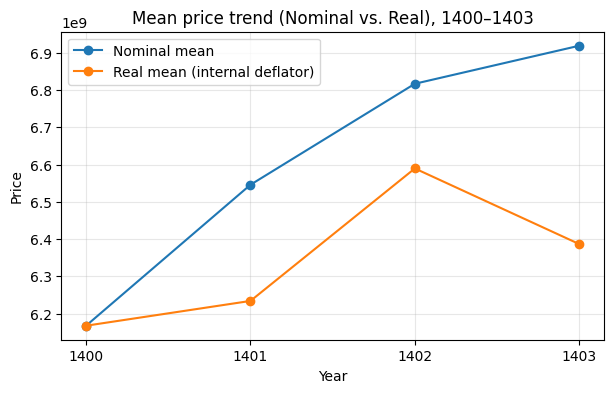

Real-price trend (internal_index(price_per_m2 using building_size; base=1400)): increasing ~ 3.6% from 1400 to 1403.


In [58]:
# =========================
# Data Analysis Part 7 : Real-price trend (1400–1403)
# =========================

YEARS = [1400, 1401, 1402, 1403]

# Nominal yearly mean
df_price = df[(df[price_col].notna()) & (df[price_col] > 0)]
mean_nominal = (df_price[df_price["year_shamsi"].isin(YEARS)]
                .groupby("year_shamsi")[price_col].mean()
                .rename("mean_nominal").to_frame())

# Option A: CPI-based (fill with actual CPI values if available; base 1400 = 100)
CPI_ANNUAL = {
    # 1400: 100.0,
    # 1401: 147.0,
    # 1402: 210.0,
    # 1403: 280.0,
}

def real_via_cpi(mean_nominal_df, cpi_dict, base_year=1400):
    """Real = nominal / (CPI_y / CPI_base). Returns None if CPI missing."""
    idx, reals = [], []
    for y, v in mean_nominal_df["mean_nominal"].items():
        if (y in cpi_dict) and (base_year in cpi_dict) and cpi_dict[base_year] > 0:
            reals.append(v / (cpi_dict[y] / cpi_dict[base_year]))
            idx.append(y)
    if not idx:
        return None
    return pd.DataFrame({
        "mean_nominal": [mean_nominal_df.loc[y, "mean_nominal"] for y in idx],
        "mean_real_cpi": reals
    }, index=idx)

def real_via_internal_deflator(df_full, mean_nominal_df, years, price_col, size_col, imp_flag_col=None):
    """
    Internal deflator using median price-per-m2 by year (robust):
      - Try excluding imputed sizes; if not enough, include them.
      - Prefer base=1400 if available; else use the earliest available year in YEARS.
    Returns: (trend_table, base_year_used).
    """
    if (size_col is None) or (size_col not in df_full.columns):
        raise ValueError("No valid area column for internal deflator.")

    def build_med_ppm(include_imputed=False):
        d = df_full[(df_full[size_col].notna()) & (df_full[size_col] > 0) & (df_full[price_col].notna())].copy()
        if (imp_flag_col is not None) and (imp_flag_col in d.columns) and (not include_imputed):
            d = d[d[imp_flag_col] == False]
        d["price_per_m2"] = d[price_col] / d[size_col]
        med = (d[d["year_shamsi"].isin(years)]
               .groupby("year_shamsi")["price_per_m2"].median())
        return med

    # 1) Exclude imputed sizes
    med_ppm = build_med_ppm(include_imputed=False)
    usable_years = [y for y in years if (y in med_ppm.index) and pd.notna(med_ppm.loc[y])]

    # 2) If none, include imputed sizes
    if not usable_years:
        med_ppm = build_med_ppm(include_imputed=True)
        usable_years = [y for y in years if (y in med_ppm.index) and pd.notna(med_ppm.loc[y])]

    if not usable_years:
        raise RuntimeError("Internal deflator failed: no median price-per-m2 for the requested years.")

    base_year_used = 1400 if 1400 in usable_years else min(usable_years)

    ratio = med_ppm / med_ppm.loc[base_year_used]
    out = mean_nominal_df.join(ratio.rename("median_ppm2").to_frame(), how="left")
    out["mean_real_internal"] = out["mean_nominal"] / out["median_ppm2"]
    return out, base_year_used

# Pick area column (prefer building area; else land; else None)
area_col_for_deflator = size_build_col if size_build_col else (size_land_col if size_land_col else None)
imp_flag_for_area     = f"{area_col_for_deflator}_imputed" if area_col_for_deflator else None

trend_tbl = None
method_used = None

# Try CPI first
if CPI_ANNUAL:
    trend_tbl = real_via_cpi(mean_nominal, CPI_ANNUAL, base_year=1400)
    if trend_tbl is not None:
        method_used = "CPI"

# Else internal deflator
if trend_tbl is None and area_col_for_deflator is not None:
    try:
        trend_tbl, base_used = real_via_internal_deflator(
            df, mean_nominal, YEARS, price_col,
            area_col_for_deflator, imp_flag_for_area
        )
        method_used = f"internal_index(price_per_m2 using {area_col_for_deflator}; base={base_used})"
    except Exception as e:
        print("[Task 7] Internal deflator failed:", e)

# Final fallback: nominal only
if trend_tbl is None:
    trend_tbl = mean_nominal.copy()
    trend_tbl["note"] = "Real-price not computed (no CPI & no suitable area column)."
    method_used = "nominal_only"

print("\n[Task 7] Annual trend of mean price (nominal vs. real) for 1400–1403:")
display(trend_tbl)

# Plot
plt.figure(figsize=(7,4))
plt.plot(trend_tbl.index, trend_tbl["mean_nominal"], marker="o", label="Nominal mean")
if "mean_real_cpi" in trend_tbl.columns:
    plt.plot(trend_tbl.index, trend_tbl["mean_real_cpi"], marker="o", label="Real mean (CPI-based)")
if "mean_real_internal" in trend_tbl.columns:
    plt.plot(trend_tbl.index, trend_tbl["mean_real_internal"], marker="o", label="Real mean (internal deflator)")
plt.title("Mean price trend (Nominal vs. Real), 1400–1403")
plt.xlabel("Year"); plt.ylabel("Price")
plt.xticks([1400, 1401, 1402, 1403])
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# Quick textual summary based on real series if present
col_real = "mean_real_cpi" if "mean_real_cpi" in trend_tbl.columns \
           else ("mean_real_internal" if "mean_real_internal" in trend_tbl.columns else None)
if col_real:
    # Pick a start/end available in table
    years_in_tbl = [y for y in YEARS if y in trend_tbl.index and pd.notna(trend_tbl.loc[y, col_real])]
    if len(years_in_tbl) >= 2:
        start_y, end_y = years_in_tbl[0], years_in_tbl[-1]
        start_v, end_v = trend_tbl.loc[start_y, col_real], trend_tbl.loc[end_y, col_real]
        if start_v and start_v > 0:
            pct_change = 100 * (end_v - start_v) / start_v
            direction = "increasing" if pct_change > 2 else ("decreasing" if pct_change < -2 else "$\approx$" "flat")
            print(f"Real-price trend ({method_used}): {direction} ~ {pct_change:.1f}% from {start_y} to {end_y}.")
else:
    print("Real-price not available; showing nominal means only. Provide CPI or an area column for internal deflator.")


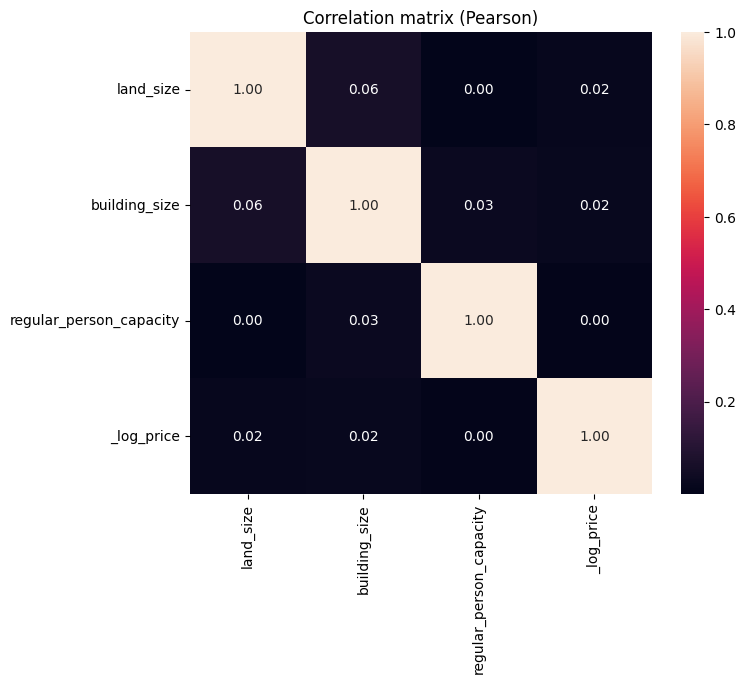

In [59]:
# =========================
# TASK 8: Correlation matrix
# =========================

# Build the variable list (use _log_price instead of raw price to reduce skew)
corr_cols = []
if size_land_col:  corr_cols.append(size_land_col)
if size_build_col: corr_cols.append(size_build_col)
if capacity_col:   corr_cols.append(capacity_col)
if rooms_col:      corr_cols.append(rooms_col)
if lat_col:        corr_cols.append(lat_col)
if lon_col:        corr_cols.append(lon_col)
corr_cols.append("_log_price")  # log(price)

corr_df = df[corr_cols].copy()
corr = corr_df.corr(method="pearson")

plt.figure(figsize=(7.5,6))
sns.heatmap(corr, annot=True, fmt=".2f", square=True)
plt.title("Correlation matrix (Pearson)")
plt.show()


In [63]:
# =========================
# HYPOTHESIS TEST (part 4)
# =========================

# Guard: ensure roll-ups exist
assert "has_luxury" in df.columns and "has_nonlux" in df.columns, "Run the updated PREPARING DATA block first."

# Use log(price) for tests
df_ht = df[(df["_log_price"].notna())].copy()

def welch_ttest(x, y):
    return stats.ttest_ind(x, y, equal_var=False, nan_policy="omit")

def mannwhitney(x, y):
    # SciPy warns if min(n1, n2) < required; we'll guard manually.
    return stats.mannwhitneyu(x, y, alternative="two-sided")

def cohens_d_log(x, y):
    x = pd.Series(x).dropna(); y = pd.Series(y).dropna()
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2: return np.nan
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    pooled_sd = math.sqrt(((nx-1)*vx + (ny-1)*vy) / (nx+ny-2)) if (nx+ny-2)>0 else np.nan
    if pooled_sd == 0 or np.isnan(pooled_sd): return np.nan
    return (x.mean() - y.mean()) / pooled_sd

def compare_groups(flag_col, label, min_n=20):
    g1 = df_ht.loc[df_ht[flag_col] == True, "_log_price"]
    g0 = df_ht.loc[df_ht[flag_col] == False, "_log_price"]
    n1, n0 = int(g1.notna().sum()), int(g0.notna().sum())
    if (n1 < min_n) or (n0 < min_n):
        return {
            "group": label, "n_with": n1, "n_without": n0,
            "Welch_t": np.nan, "Welch_p": np.nan,
            "MannWhitney_U": np.nan, "MannWhitney_p": np.nan,
            "Cohen_d_logprice": np.nan,
            "Δ mean (nominal)": np.nan,
            "note": f"Too few samples (need >= {min_n} in each group)."
        }
    t = welch_ttest(g1, g0)
    u = mannwhitney(g1, g0)
    diff_nominal = df.loc[df[flag_col] == True, price_col].mean() - \
                   df.loc[df[flag_col] == False, price_col].mean()
    return {
        "group": label, "n_with": n1, "n_without": n0,
        "Welch_t": t.statistic, "Welch_p": t.pvalue,
        "MannWhitney_U": u.statistic, "MannWhitney_p": u.pvalue,
        "Cohen_d_logprice": cohens_d_log(g1, g0),
        "Δ mean (nominal)": diff_nominal
    }

# (a) Any luxury vs none
# (b) Any non-luxury vs none
results = [
    compare_groups("has_luxury", "Any Luxury"),
    compare_groups("has_nonlux", "Any Non-Luxury")
]

print("\n[Hypothesis Test - Part 4] Group-level results:")
display(pd.DataFrame(results))

# Optional: per-feature non-luxury tests + FDR correction (only if we actually have non-lux features)
nonlux_cols_present = [c for c in [
    "balcony_has","elevator_has","warehouse_has","parking_has","guard_security_has",
    "system_heating_has","system_cooling_has","restroom_has","water_has","electricity_has","gas_has"
] if c in df_ht.columns]

per_feat, pvals = [], []
for c in nonlux_cols_present:
    res = compare_groups(c, c)
    per_feat.append(res)
    if not np.isnan(res.get("Welch_p", np.nan)):
        pvals.append(res["Welch_p"])

def fdr_bh(pvals):
    pvals = np.array(pvals, dtype=float)
    if len(pvals) == 0:
        return []
    n = len(pvals)
    order = np.argsort(pvals)
    ranked = pvals[order]
    q = np.zeros(n); prev = 1.0
    for i in range(n-1, -1, -1):
        rank = i+1
        q[i] = min(prev, ranked[i]*n/rank)
        prev = q[i]
    q_adj = np.empty(n); q_adj[order] = q
    return q_adj.tolist()

if pvals:
    qvals = fdr_bh(pvals)
    j = 0
    for i in range(len(per_feat)):
        if not np.isnan(per_feat[i].get("Welch_p", np.nan)):
            per_feat[i]["Welch_q(FDR)"] = qvals[j]; j += 1

if per_feat:
    print("\nPer-feature non-luxury tests (FDR-adjusted):")
    display(pd.DataFrame(per_feat).sort_values(["Welch_q(FDR)","Welch_p"], na_position="last"))

# Short textual verdict
def verdict(row, alpha=0.05):
    p_w = row.get("Welch_p", np.nan)
    p_u = row.get("MannWhitney_p", np.nan)
    if not np.isnan(p_w) and p_w < alpha:
        return "Significant (Welch)"
    if not np.isnan(p_u) and p_u < alpha:
        return "Significant (Mann–Whitney)"
    note = row.get("note")
    return "Insufficient sample" if note else "Not significant"

print("\nSummary:")
for r in results:
    d = r.get("Cohen_d_logprice", np.nan)
    dm = r.get("Δ mean (nominal)", np.nan)
    # d_str  = "nan" if np.isnan(d)  else f"{d:.2f}"
    # dm_str = "nan" if np.isnan(dm) else f"{dm:,.0f}"
    print(f"- {r['group']}: {verdict(r)} | d ~ {d} | Δmean≈{dm}")



[Hypothesis Test - Part 4] Group-level results:


,group,n_with,n_without,Welch_t,Welch_p,MannWhitney_U,MannWhitney_p,Cohen_d_logprice,Δ mean (nominal)
0,Any Luxury,28929,537515,45.595897,0.0,9.826617e+09,0.0,0.319400,6.397245e+09
1,Any Non-Luxury,340699,225745,49.572208,0.0,4.168784e+10,0.0,0.138959,-8.322589e+07



Summary:
- Any Luxury: Significant (Welch) | d ~ 0.31939950500313563 | Δmean≈6397244811.580427
- Any Non-Luxury: Significant (Welch) | d ~ 0.13895939684022174 | Δmean≈-83225893.0769558
